In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification
from tqdm import tqdm

2026-01-23 17:50:48.689615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769190648.919105      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769190648.990849      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769190649.580458      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769190649.580508      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769190649.580511      55 computation_placer.cc:177] computation placer alr

In [3]:
df = pd.read_csv("/kaggle/input/news-sentiment-dataset/nepali_news_sentiment.csv")  # change path

# Quick look
df.head()

,id,headline,category,sentiment
0,1,नेपालको आर्थिक वृद्धिदरमा सुधार हुने प्रक्षेपण,Economy,1
1,2,त्रिभुवन अन्तर्राष्ट्रिय विमानस्थलमा विमान दुर...,Disaster,-1
2,3,सरकारले नयाँ बजेट सार्वजनिक गर्‍यो,Politics,0
3,4,नेपाली क्रिकेट टोलीको ऐतिहासिक जित,Sports,1
4,5,"देशभर भारी वर्षाको सम्भावना, सतर्क रहन आग्रह",Weather,-1


Total rows: 2200, Total columns: 4

Missing values per column:
id           0
headline     0
category     0
sentiment    0
dtype: int64
Empty headlines: 0

Class distribution:
sentiment
 1    1250
-1     753
 0     197
Name: count, dtype: int64


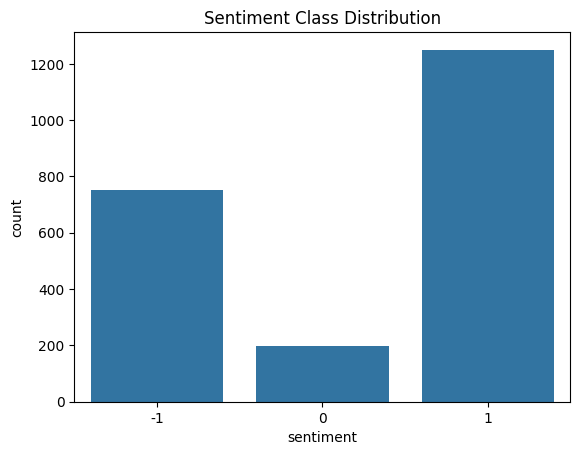

In [4]:
print(f"Total rows: {df.shape[0]}, Total columns: {df.shape[1]}")

# Missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Empty headlines
empty_headlines = (df['headline'].str.strip() == "").sum()
print(f"Empty headlines: {empty_headlines}")

# Drop missing or empty rows
df = df.dropna(subset=['headline', 'sentiment'])
df = df[df['headline'].str.strip() != ""]

# Class distribution
print("\nClass distribution:")
print(df['sentiment'].value_counts())
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Class Distribution")
plt.show()


In [6]:
def clean_nepali_text(text):
    text = str(text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_headline'] = df['headline'].apply(clean_nepali_text)
df.head()

,id,headline,category,sentiment,clean_headline
0,1,नेपालको आर्थिक वृद्धिदरमा सुधार हुने प्रक्षेपण,Economy,1,नेपालको आर्थिक वृद्धिदरमा सुधार हुने प्रक्षेपण
1,2,त्रिभुवन अन्तर्राष्ट्रिय विमानस्थलमा विमान दुर...,Disaster,-1,त्रिभुवन अन्तर्राष्ट्रिय विमानस्थलमा विमान दुर...
2,3,सरकारले नयाँ बजेट सार्वजनिक गर्‍यो,Politics,0,सरकारले नयाँ बजेट सार्वजनिक गर्‍यो
3,4,नेपाली क्रिकेट टोलीको ऐतिहासिक जित,Sports,1,नेपाली क्रिकेट टोलीको ऐतिहासिक जित
4,5,"देशभर भारी वर्षाको सम्भावना, सतर्क रहन आग्रह",Weather,-1,"देशभर भारी वर्षाको सम्भावना, सतर्क रहन आग्रह"


In [7]:
le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['sentiment'])
print(df[['sentiment', 'sentiment_encoded']].head())
num_labels = df['sentiment_encoded'].nunique()
print("Number of classes:", num_labels)

   sentiment  sentiment_encoded
0          1                  2
1         -1                  0
2          0                  1
3          1                  2
4         -1                  0
Number of classes: 3


In [8]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['clean_headline'], df['sentiment_encoded'], test_size=0.2, random_state=42, stratify=df['sentiment_encoded']
)

print(f"Training samples: {len(train_texts)}, Validation samples: {len(val_texts)}")

Training samples: 1760, Validation samples: 440


In [9]:
tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=128, return_tensors="pt")
val_encodings = tokenizer(list(val_texts), padding=True, truncation=True, max_length=128, return_tensors="pt")

# Convert labels to tensors
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Sanity check
assert train_labels_tensor.min() >= 0 and train_labels_tensor.max() < num_labels
assert val_labels_tensor.min() >= 0 and val_labels_tensor.max() < num_labels
print("All labels are valid!")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

All labels are valid!


In [10]:
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels_tensor)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", num_labels=num_labels
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = CrossEntropyLoss()


Using device: cuda


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
epochs = 20
for epoch in range(epochs):
    model.train()
    loop = tqdm(train_loader, leave=True)
    total_loss = 0
    for batch in loop:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())
    
    print(f"Epoch {epoch+1} finished. Average loss: {total_loss/len(train_loader)}")


Epoch 1: 100%|██████████| 110/110 [00:16<00:00,  6.66it/s, loss=0.326] 


Epoch 1 finished. Average loss: 0.2174786193634976


Epoch 2: 100%|██████████| 110/110 [00:16<00:00,  6.64it/s, loss=0.0174]


Epoch 2 finished. Average loss: 0.15281378184021874


Epoch 3: 100%|██████████| 110/110 [00:16<00:00,  6.60it/s, loss=0.022] 


Epoch 3 finished. Average loss: 0.1481659792786972


Epoch 4: 100%|██████████| 110/110 [00:16<00:00,  6.55it/s, loss=0.00945]


Epoch 4 finished. Average loss: 0.1164198187857189


Epoch 5: 100%|██████████| 110/110 [00:16<00:00,  6.51it/s, loss=0.0465] 


Epoch 5 finished. Average loss: 0.08806624229658734


Epoch 6: 100%|██████████| 110/110 [00:17<00:00,  6.45it/s, loss=0.0686]


Epoch 6 finished. Average loss: 0.09715157797221433


Epoch 7: 100%|██████████| 110/110 [00:17<00:00,  6.42it/s, loss=0.0186] 


Epoch 7 finished. Average loss: 0.05425679426513274


Epoch 8: 100%|██████████| 110/110 [00:17<00:00,  6.41it/s, loss=0.0342] 


Epoch 8 finished. Average loss: 0.06504242390986871


Epoch 9: 100%|██████████| 110/110 [00:17<00:00,  6.43it/s, loss=0.102]  


Epoch 9 finished. Average loss: 0.0459817235739055


Epoch 10: 100%|██████████| 110/110 [00:17<00:00,  6.41it/s, loss=0.0438] 


Epoch 10 finished. Average loss: 0.06142853031421758


Epoch 11: 100%|██████████| 110/110 [00:17<00:00,  6.39it/s, loss=0.0129] 


Epoch 11 finished. Average loss: 0.046383462078996344


Epoch 12: 100%|██████████| 110/110 [00:17<00:00,  6.38it/s, loss=0.00116]


Epoch 12 finished. Average loss: 0.01597477051704614


Epoch 13: 100%|██████████| 110/110 [00:17<00:00,  6.38it/s, loss=0.00316]


Epoch 13 finished. Average loss: 0.035035164437828246


Epoch 14: 100%|██████████| 110/110 [00:17<00:00,  6.38it/s, loss=0.00523]


Epoch 14 finished. Average loss: 0.049810230392772194


Epoch 15: 100%|██████████| 110/110 [00:17<00:00,  6.38it/s, loss=0.00117]


Epoch 15 finished. Average loss: 0.033170914892848076


Epoch 16: 100%|██████████| 110/110 [00:17<00:00,  6.38it/s, loss=0.00262] 


Epoch 16 finished. Average loss: 0.023303135654846714


Epoch 17: 100%|██████████| 110/110 [00:17<00:00,  6.39it/s, loss=0.0024] 


Epoch 17 finished. Average loss: 0.021198626776458694


Epoch 18: 100%|██████████| 110/110 [00:17<00:00,  6.36it/s, loss=0.00234]


Epoch 18 finished. Average loss: 0.026529775607526642


Epoch 19: 100%|██████████| 110/110 [00:17<00:00,  6.31it/s, loss=0.000964]


Epoch 19 finished. Average loss: 0.011848905574615029


Epoch 20: 100%|██████████| 110/110 [00:17<00:00,  6.25it/s, loss=0.00169]

Epoch 20 finished. Average loss: 0.022527512959310447


In [18]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(
    all_labels, 
    all_preds, 
    target_names=[str(c) for c in le.classes_]
))


              precision    recall  f1-score   support

          -1       0.92      0.96      0.94       151
           0       0.68      0.67      0.68        39
           1       0.96      0.94      0.95       250

    accuracy                           0.92       440
   macro avg       0.86      0.86      0.86       440
weighted avg       0.92      0.92      0.92       440



In [22]:
model.save_pretrained("./xlmroberta_nepali_sentiment_manual")
tokenizer.save_pretrained("./xlmroberta_nepali_sentiment_manual")

('./xlmroberta_nepali_sentiment_manual/tokenizer_config.json',
 './xlmroberta_nepali_sentiment_manual/special_tokens_map.json',
 './xlmroberta_nepali_sentiment_manual/sentencepiece.bpe.model',
 './xlmroberta_nepali_sentiment_manual/added_tokens.json')

In [31]:
import torch
import re
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizer
import pandas as pd

# -----------------------------
# 1. Device setup
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# 2. Load fine-tuned model & tokenizer
# -----------------------------
model_path = "xlmroberta_nepali_sentiment_manual"  # folder with pytorch_model.bin, config.json, tokenizer.json
model = XLMRobertaForSequenceClassification.from_pretrained(model_path).to(device)
tokenizer = XLMRobertaTokenizer.from_pretrained(model_path)

# -----------------------------
# 3. Recreate LabelEncoder from training classes
# -----------------------------
# Replace this list with the sentiments you used during training
sentiment_classes = ["positive", "negative", "neutral"]  # adjust as per your dataset
class_to_id = {c: i for i, c in enumerate(sentiment_classes)}
id_to_class = {i: c for c, i in class_to_id.items()}

# -----------------------------
# 4. Clean Nepali text
# -----------------------------
def clean_text(text):
    text = str(text)
    text = re.sub(r"[^अ-ह०-९\s]", "", text)  # keep only Nepali letters and digits
    text = re.sub(r"\s+", " ", text).strip()
    return text

# -----------------------------
# 5. Inference function
# -----------------------------
def predict_sentiment(headline):
    text = clean_text(headline)
    
    # Tokenize
    inputs = tokenizer(
        text, return_tensors="pt", truncation=True, padding=True, max_length=128
    ).to(device)
    
    # Predict
    model.eval()
    with torch.no_grad():
        logits = model(**inputs).logits
    pred_id = torch.argmax(logits, dim=1).item()
    
    # Map to sentiment string
    pred_label = id_to_class[pred_id]
    return pred_label

# -----------------------------
# 6. Example usage
# -----------------------------
example_headlines = [
    # Positive
    "नेपालले ओलम्पिक खेलमा सुन जित्यो",
    "नयाँ विद्यालयले उत्कृष्ट परिणाम ल्यायो",
    "पर्यटन क्षेत्रमा वृद्धि भएको छ",
    "कृषि उत्पादनमा अभूतपूर्व सफलता",
    "स्थानीय खेलकुद टोलीले उपाधि जित्यो",
    "सहरमा सफा र हरियो वातावरण निर्माण भयो",
    "स्वास्थ्य सेवामा सुधार आएको छ",

    # Negative
    "देशमा आर्थिक संकट गहिरो हुँदैछ",
    "बाढीले घर र सडक क्षति पुर्‍यायो",
    "रोजगारी दर घट्दै गएको छ",
    "सडक दुर्घटनामा धेरैको मृत्यु",
    "स्वास्थ्य सेवामा समस्या बढ्दै गएको छ",
    "महँगाईले जनजीवन कष्टकर बनाएको छ",
    "सिंचाइ अभावले किसानलाई नोक्सान",

    # Neutral
    "नेपाल र भारतबीच बैठक सम्पन्न भयो",
    "सडक निर्माण परियोजना सुरु भयो",
    "सांस्कृतिक उत्सव यही हप्तामा आयोजना हुँदैछ",
    "नयाँ शिक्षा नीति सार्वजनिक गरिएको छ",
    "पानी आपूर्ति योजना अगाडि बढ्दैछ",
    "स्थानीय चुनावको मिति घोषणा भयो",
    "सुरक्षाबलले सामान्य गस्ती सञ्चालन गर्यो"
]
for h in example_headlines:
    sentiment = predict_sentiment(h)
    print(f"Headline: {h}")
    print(f"Predicted Sentiment: {sentiment}\n")


Using device: cuda
Headline: नेपालले ओलम्पिक खेलमा सुन जित्यो
Predicted Sentiment: neutral

Headline: नयाँ विद्यालयले उत्कृष्ट परिणाम ल्यायो
Predicted Sentiment: neutral

Headline: पर्यटन क्षेत्रमा वृद्धि भएको छ
Predicted Sentiment: positive

Headline: कृषि उत्पादनमा अभूतपूर्व सफलता
Predicted Sentiment: neutral

Headline: स्थानीय खेलकुद टोलीले उपाधि जित्यो
Predicted Sentiment: neutral

Headline: सहरमा सफा र हरियो वातावरण निर्माण भयो
Predicted Sentiment: positive

Headline: स्वास्थ्य सेवामा सुधार आएको छ
Predicted Sentiment: positive

Headline: देशमा आर्थिक संकट गहिरो हुँदैछ
Predicted Sentiment: positive

Headline: बाढीले घर र सडक क्षति पुर्‍यायो
Predicted Sentiment: positive

Headline: रोजगारी दर घट्दै गएको छ
Predicted Sentiment: positive

Headline: सडक दुर्घटनामा धेरैको मृत्यु
Predicted Sentiment: positive

Headline: स्वास्थ्य सेवामा समस्या बढ्दै गएको छ
Predicted Sentiment: positive

Headline: महँगाईले जनजीवन कष्टकर बनाएको छ
Predicted Sentiment: positive

Headline: सिंचाइ अभावले किसानल